In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
import bt_tools as bt

In [26]:
bde_homo = [-0.156342,
-0.120096,
-0.086467,
-0.060537]

[-0.122629,
 -0.085471,
 -0.094782,
 -0.086457

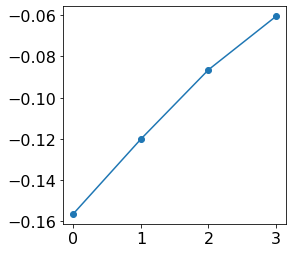

In [27]:
plt.plot(bde_homo, '-o')
plt.plot()

In [31]:
data.loc[data['smiles'] == 'BrBr']

,smiles,Z1,Z2,d,energy,bfe
29,BrBr,35,35,2.281337,-5147.706716,-0.086457


In [2]:
weighted_core = lambda Ne, Zs, Zp: 2*Zs/Ne + (Ne-2)/Ne*Zp

zs2 = np.array([3.217, 3.847, 4.492, 5.128])
zp2 = np.array([3.136, 3.834, 4.453, 5.100])

zs3 = np.array([4.903, 	5.642, 	6.367, 	7.068])
zp3 = np.array([4.285, 4.886, 5.482, 6.116])

zs4 = np.array([8.044, 	8.944, 	9.758, 	10.553])
zp4 = np.array([6.780, 7.449, 8.287, 9.028])

zs = [zs2, zs3, zs4]
zp = [zp2, zp3, zp4]
ne = [4, 5, 6, 7]
z_eff = []
for rs, rp in zip(zs, zp):
    zr = []
    for s, p, n in zip(rs, rp, ne):
        zr.append(weighted_core(n, s, p))
    z_eff.extend(zr)
    
Z2Zeff = dict()
for Z, Zeff in zip([6,7,8,9,14,15,16,17,32,33,34,35], z_eff):
    Z2Zeff[Z] = Zeff

In [3]:
be = {'H-H':104.2, 'Li-Li':26.5, 'C-C':83.1, 'N-N':38.4, 'O-O':33.2, 'F-F':36.6,
     'C-H':98.8, 'N-H':93.4, 'O-H':110.6, 'F-H':134.6}

chi = {'H':2.1, 'Li':1.0, 'C':2.5, 'N':3.0, 'O':3.5, 'F':4.0}

def get_EAB(A, B):
    E_AB = (be[f'{A}-{A}'] + be[f'{B}-{B}'])/2 + 23*(chi[A]-chi[B])**2
    return(E_AB)

In [4]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/all_energies.csv')
data_2 = data.loc[(data['Z1'] <= 9) & (data['Z2'] <= 9)].to_dict('list')
data_3 = data.loc[(data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17)].to_dict('list')
data_4 = data.loc[(data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')
data_234 = data.loc[(data['Z1'] <= 9) & (data['Z2'] <= 9) | (data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17) | (data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')

for d in [data_2, data_3, data_4, data_234]:
    d['unit'] = 630
    d['bfe type'] = 'homo'
    
    Z1_eff = []
    Z2_eff = []
    for Z1, Z2 in zip(d['Z1'], d['Z2']):
        Z1_eff.append(Z2Zeff[Z1])
        Z2_eff.append(Z2Zeff[Z2])
        
    #d['Z1'] = Z1_eff
    #d['Z2'] = Z2_eff
    #d['nbfe'] = np.array(d['Z1'])*np.array(d['Z2'])-(np.array(d['Z1'])+np.array(d['Z2']))
    
# do linear fits
b2 = bt.BDE_clean.fromdict(data_2)
b3 = bt.BDE_clean.fromdict(data_3)
b4 = bt.BDE_clean.fromdict(data_4)
for b in [b2, b3, b4]:
    b.linear_fit()
    print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))
    
# non-linear fits

def non_linear_model(var, a, b, c):
    Z1, Z2 = var.T
    ebfe = -a**2 - b**2*Z1*Z2 -c**2*(Z1**(7/3)+Z2**(7/3))#(-beta*(Z1**(7/3)+Z2**(7/3))+alpha-b_prime*Z1*Z2)
    return(ebfe)

# do linear fits
b2_nl = bt.BDE_clean.fromdict(data_2)
b3_nl = bt.BDE_clean.fromdict(data_3)
b4_nl = bt.BDE_clean.fromdict(data_4)

for b in [b2_nl, b3_nl, b4_nl]:
    b.fit(non_linear_model)
    print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))

MAE = 0.5134766712980074
MAE = 0.38930744595067424
MAE = 0.3274963089508717
MAE = 0.9976124613595921
MAE = 2.346632511294735
MAE = 2.172271601444673


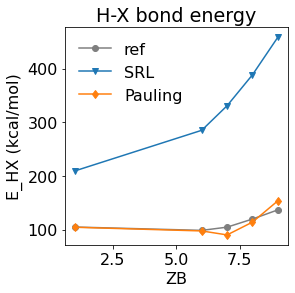

In [5]:
bd_nl = b2_nl

H_bond_exp={'H-H':436, 'C-H':410, 'H-NH2':435, 'H-OH':498, 'H-F':569}

H_bond_exp_Pauling={'H-H':104.2, 'C-H':410, 'H-NH2':435, 'H-OH':498, 'H-F':569}

for k in H_bond_exp.keys():
    H_bond_exp[k] = H_bond_exp[k]*0.24
H_bond_model = dict()

# BDE from SRL
for k, ZB in zip(H_bond_exp.keys(), [1,6,7,8,9]):
    ZA = 1
    E_AB = -(-bd_nl.params[0][0]**2 -bd_nl.params[0][1]**2*ZA*ZB -bd_nl.params[0][2]**2*(ZA**(7/3)+ZB**(7/3)) + ZA*ZB*630)
    H_bond_model[k] = E_AB
    
# BDE from Pauling
H_bond_Pauling = dict()
ref_pauling = dict()
for el in ['H', 'C', 'N', 'O', 'F']:
    H_bond_Pauling[f'H-{el}'] = get_EAB('H', el)
    ref_pauling[f'{el}-H'] = be[f'{el}-H']

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [4,4]
plt.title('H-X bond energy')
plt.plot([1,6,7,8,9], list(H_bond_exp.values()), '-o', color = 'tab:gray', label= 'ref')
plt.plot([1,6,7,8,9], list(H_bond_model.values()), '-v', color = 'tab:blue', label = 'SRL')
#plt.plot([1,6,7,8,9], list(ref_pauling.values()), '--d', color = 'tab:orange', label = 'ref Pauling')
plt.plot([1,6,7,8,9], list(H_bond_Pauling.values()), '-d', color = 'tab:orange', label = 'Pauling')
plt.xlabel('ZB')
plt.ylabel('E_HX (kcal/mol)')
plt.legend(frameon = False)
#plt.savefig('/home/sahre/work/bonding_trends/figures/results/HX_bonds.png', bbox_inches='tight')

Text(0, 0.5, 'E_LiX (kcal/mol)')

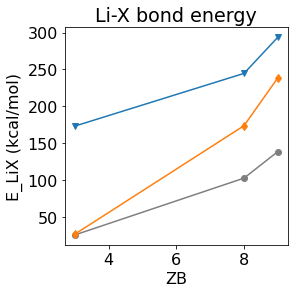

In [6]:
Li_bond_exp={'Li-Li':106, 'Li-OH':427, 'Li-F':577}
for k in Li_bond_exp.keys():
    Li_bond_exp[k] = Li_bond_exp[k]*0.24
Li_bond_model = dict()
for k, ZB in zip(Li_bond_exp.keys(), [3,8,9]):
    ZA = 3
    E_AB = -(-bd_nl.params[0][0]**2 -bd_nl.params[0][1]**2*ZA*ZB -bd_nl.params[0][2]**2*(ZA**(7/3)+ZB**(7/3)) + ZA*ZB*630)
    Li_bond_model[k] = E_AB

    
# BDE from Pauling
Li_bond_Pauling = dict()
for el in ['Li', 'O', 'F']:
    Li_bond_Pauling[f'Li-{el}'] = get_EAB('Li', el)

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [4,4]

plt.title('Li-X bond energy')
plt.plot([3,8,9], list(Li_bond_exp.values()), '-o', color = 'tab:gray', label= 'ref')
plt.plot([3,8,9], list(Li_bond_model.values()), '-v', color = 'tab:blue', label = 'SRL')
plt.plot([3,8,9], list(Li_bond_Pauling.values()), '-d', color = 'tab:orange', label = 'Pauling')
plt.xlabel('ZB')
plt.ylabel('E_LiX (kcal/mol)')
#plt.legend(frameon = False)
#plt.savefig('/home/sahre/work/bonding_trends/figures/results/LiX_bonds.png', bbox_inches='tight')

In [7]:
get_EAB('H', 'N')

89.92999999999999

In [8]:
{'H-H':104.2, 'C-C':83.1, 'N-N':38.4, 'O-O':33.2, 'F-F':36.6}

{'H-H': 104.2, 'C-C': 83.1, 'N-N': 38.4, 'O-O': 33.2, 'F-F': 36.6}

In [9]:
be = {'H-H':104.2, 'Li-Li':26.5, 'C-C':83.1, 'N-N':38.4, 'O-O':33.2, 'F-F':36.6,
     'C-H':98.8, 'N-H':93.4, 'O-H':110.6, 'F-H':134.6,
     'C-N':69.7, 'C-O':84.0, 'C-F':105.4, 
     'N-F':64.5, 'O-F':44.2}

# mixed compounds with pauling

In [10]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')
datadict = data.to_dict('list')
datadict['bfe type'] = 'homo'

energies_ref = -630*np.array(datadict['bfe'])

### SRL

In [11]:
def model_dbar(*args):
    globals()['model_dbar_lat'] = args[1:]
    var = args[0]
    alpha2, beta2, dbar2, alpha3, beta3, dbar3, alpha4, beta4, dbar4, b_prime = args[1:11]
    y_vec = []
    for x in var:
        Z1, Z2= x[0], x[1]
        
        if Z1 >= 6 and Z1 <= 9:
            y = -beta2**2*(Z1**(7/3)+Z2**(7/3))-alpha2**2-(b_prime**2+1/dbar2**2)*Z1*Z2
        elif Z1 >= 14 and Z1 <= 17:
            y = -beta3**2*(Z1**(7/3)+Z2**(7/3))-alpha3**2-(b_prime**2+1/dbar3**2)*Z1*Z2
        elif Z1 >= 32 and Z1 <= 35:
            y = -beta4**2*(Z1**(7/3)+Z2**(7/3))-alpha4**2-(b_prime**2+1/dbar4**2)*Z1*Z2
        y_vec.append(y)

    return(y_vec)

def model_mixed(*args):
    globals()['model_dbar_lat'] = args[1:]
    var = args[0]
    alpha2, beta2, dbar2, alpha3, beta3, dbar3, alpha4, beta4, dbar4, b_prime = args[1:11]
    y_vec = []
    for x in var:
        Z1, Z2= x[0], x[1]
            
        if Z1 >= 6 and Z1 <= 9:
            alpha_1 = alpha2
            beta_1 = beta2
            dbar_1 = dbar2
        elif Z1 >= 14 and Z1 <= 17:
            alpha_1 = alpha3
            beta_1 = beta3
            dbar_1 = dbar3
        elif Z1 >= 32 and Z1 <= 35:
            alpha_1 = alpha4
            beta_1 = beta4
            dbar_1 = dbar4
            
        if Z2 >= 6 and Z2 <= 9:
            alpha_2 = alpha2
            beta_2 = beta2
            dbar_2 = dbar2
        elif Z2 >= 14 and Z2 <= 17:
            alpha_2 = alpha3
            beta_2 = beta3
            dbar_2 = dbar3
        elif Z2 >= 32 and Z2 <= 35:
            alpha_2 = alpha4
            beta_2 = beta4
            dbar_2 = dbar4
            
        alpha_term = -(alpha_1**2 + alpha_2**2)/2
        
        beta_term = -(beta_1**2*Z1**(7/3) + beta_2**2*Z2**(7/3))
        
        dbar_term = -(1/dbar_1**2 + 1/dbar_2**2)/2*Z1*Z2
        
        b_prime_term = -b_prime*Z1*Z2
        
        y = alpha_term + beta_term + dbar_term + b_prime_term
        
        y_vec.append(y)

    return(y_vec)

In [12]:
b_mixed = bt.BDE_clean.fromdict(datadict)

b_mixed.linear_fit()
energies_lSRL = 630*b_mixed.bde_fitted
mae_lSRL = b_mixed.linear_mae*630


# non-linear model

#p0 = [alpha2, beta2, dbar2_ini, alpha3, beta3, dbar3_ini, alpha4, beta4, dbar4_ini, b_prime_ini]

p0 = np.array([0.58519201, 0.05615728, 4.        , 0.78953269, 0.04872337,
       4.        , 1.32691723, 0.03592518, 4.        , 0.37126436])

b_mixed_nl = bt.BDE_clean.fromdict(datadict)

b_mixed_nl.fit(model_mixed, p0)
mae_nlSRL = b_mixed_nl.mae*630
energies_nlSRL = b_mixed_nl.bde_fitted*630

/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [13]:
np.abs(b_mixed_nl.bde_fitted[:30]-b_mixed_nl.bde[:30]).mean()*630

13.496423686373243

In [14]:
np.abs(b_mixed.bde_fitted[:30]-b_mixed.bde[:30]).mean()*630

10.180593058811962

### Pauling

In [15]:
chi = {'H':2.1, 'Li':1.0, 'C':2.5, 'N':3.0, 'O':3.5, 'F':4.0, 'Si':1.8, 'P':2.1, 'S':2.5, 'Cl':3.0,
      'Ge':1.8, 'As':2.0, 'Se':2.4, 'Br':2.8, 'I':2.5}

Z2el = {6:'C', 7:'N', 8:'O', 9:'F', 14:'Si', 15:'P', 16:'S', 17:'Cl', 32:'Ge', 33:'As', 34:'Se', 35:'Br'}

def get_EAB(A, B):
    E_AB = (be[f'{A}-{A}'] + be[f'{B}-{B}'])/2 + 23*(chi[A]-chi[B])**2
    return(E_AB)

In [16]:
energies_pauling = []
for ZA, ZB in zip(datadict['Z1'],datadict['Z2']):

    # get energy ZAZA and ZBZB
    E_AA = -data.loc[(data['Z1']==ZA) & (data['Z2']==ZA), 'bfe'].item()*630
    E_BB = -data.loc[(data['Z1']==ZB) & (data['Z2']==ZB), 'bfe'].item()*630
    # get chi_A, B
    el_A = Z2el[ZA]
    el_B = Z2el[ZB]
    
    chi_A = chi[el_A]
    chi_B = chi[el_B]
    # calculate bond energy
    E_AB = (E_AA + E_BB)/2 + 23*(chi_A - chi_B)**2
    energies_pauling.append(E_AB)
energies_pauling = np.array(energies_pauling)

mae_pauling = (np.abs(energies_pauling-energies_ref)).mean()

In [48]:
mae_pauling

6.337749831896299

In [47]:
(np.abs(energies_pauling[:30]-energies_ref[:30])).mean()

1.3675524158612453

#### Pauling for individual rows

In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
import bt_tools as bt

In [30]:
def pauling_model(data, unit = 630):
    energies_pauling = []
    for ZA, ZB in zip(data['Z1'],data['Z2']):

        # get energy ZAZA and ZBZB
        E_AA = -data.loc[(data['Z1']==ZA) & (data['Z2']==ZA), 'bfe'].item()*unit
        E_BB = -data.loc[(data['Z1']==ZB) & (data['Z2']==ZB), 'bfe'].item()*unit
        # get chi_A, B
        el_A = Z2el[ZA]
        el_B = Z2el[ZB]

        chi_A = chi[el_A]
        chi_B = chi[el_B]
        # calculate bond energy
        E_AB = (E_AA + E_BB)/2 + 23*(chi_A - chi_B)**2
        energies_pauling.append(E_AB)
    energies_pauling = np.array(energies_pauling)
    return(energies_pauling)

In [38]:
# Pauling with W4-17 energies
data_W4_17 = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/W4-17.csv')
pauling_2_W4_17 = pauling_model(data_W4_17, 1)
#uqm.save_obj(dict(zip(list(data_W4_17['smiles']), pauling_2_W4_17)), '/data/sahre/projects/atomic-energies/data/bonding_trends/other_data/pauling_2_W4-17')

In [27]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/all_energies.csv')
data_2 = data.loc[(data['Z1'] <= 9) & (data['Z2'] <= 9)]
data_3 = data.loc[(data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17)]
data_4 = data.loc[(data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)]

In [28]:
pauling_2 = pauling_model(data_2)
bde_2 = -np.array(data_2['bfe'])*630
print(np.abs(pauling_2-bde_2).mean())

pauling_3 = pauling_model(data_3)
bde_3 = -np.array(data_3['bfe'])*630
print(np.abs(pauling_3-bde_3).mean())

pauling_4 = pauling_model(data_4)
bde_4 = -np.array(data_4['bfe'])*630
print(np.abs(pauling_4-bde_4).mean())

1.4491596221812835
2.0319684307167507
0.6215291946857022


In [29]:
pauling_4

array([72.21042554, 63.94845035, 74.24169529, 86.33905106, 53.84647516,
       60.4597201 , 68.87707587, 59.71296505, 60.77032082, 54.46767659])

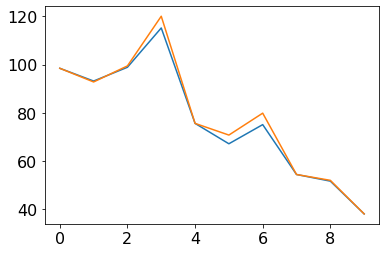

In [22]:
plt.plot(bde_2)
plt.plot(pauling_2)

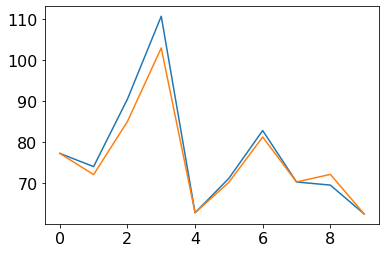

In [23]:
plt.plot(bde_3)
plt.plot(pauling_3)

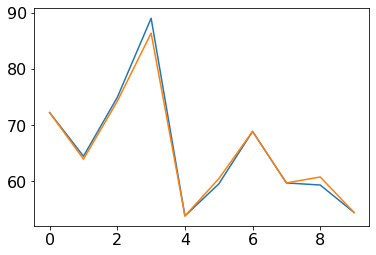

In [22]:
plt.plot(bde_4)
plt.plot(pauling_4)

### compare models

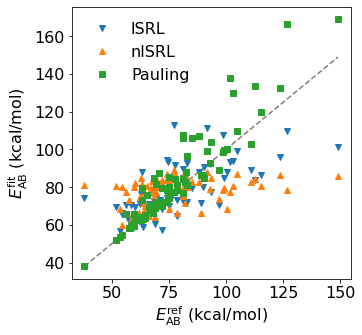

In [56]:
ref_line = [np.amin(energies_ref), np.amax(energies_ref)]

plt.rcParams['figure.figsize'] = [5,5]

plt.plot(ref_line, ref_line, '--',color = 'tab:gray')

plt.plot(energies_ref, energies_lSRL, 'v', label = 'lSRL')

plt.plot(energies_ref, energies_nlSRL, '^', label = 'nlSRL')

plt.plot(energies_ref, energies_pauling, 's', label = 'Pauling')
plt.legend(frameon = False)

plt.xlabel(r'$E_{\rm{AB}}^{\rm{ref}}$ (kcal/mol)')
plt.ylabel(r'$E_{\rm{AB}}^{\rm{fit}}$ (kcal/mol)')

#plt.savefig('/home/sahre/work/bonding_trends/figures/results/mixed_rows.png', bbox_inches='tight')

In [24]:
print(f'MAE lSRL = {mae_lSRL}')
print(f'MAE nlSRL = {mae_nlSRL}')
print(f'MAE pauling = {mae_pauling}')

MAE lSRL = 9.887231181562077
MAE nlSRL = 13.2959820114382
MAE pauling = 6.337749831896299


In [50]:
# error relative to std; value greater than one means that using the average energy will yield a lower MAE
# than the model

print(f'MAE lSRL = {mae_lSRL/energies_ref.std()}')
print(f'MAE nlSRL = {mae_nlSRL/energies_ref.std()}')
print(f'MAE pauling = {mae_pauling/energies_ref.std()}')

MAE lSRL = 0.5198081125872297
MAE nlSRL = 0.6990186825253871
MAE pauling = 0.33319882155800523
